# Задача

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. 

Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

*Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.*

## Описание тарифов

### Тариф Смарт

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
  - минута разговора: 3 рубля
  - сообщение: 3 рубля
  - 1 Гб интернет-трафика: 200 рублей
  
### Тариф Ультра

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
  - минута разговора: 1 рубль
  - сообщение: 1 рубль
  - 1 Гб интернет-трафика: 150 рублей 

### Нюансы 
- «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, засчитывается целая минута.

# Изучим данные

Поскольку они хранятся в куче разных файлов, на данном этапе попробуем, что можно, собрать в один DF для более удобного анализа. Список файлов:
- /datasets/calls.csv. 
- /datasets/internet.csv. 
- /datasets/messages.csv. 
- /datasets/tariffs.csv. 
- /datasets/users.csv.

In [1]:
import pandas as pd

df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

# Изучим данные по каждой таблице, для этого соберем все в один список и с помощью цикла обратимся к данным
# Ремарка, в данном случае мне это не кажется супер удобным, но в замечаниях ревью к прошлому проекту 
# просили для однотипных операций искать одно решение, стараюсь следовать

df_list = (df_users, df_tariffs, df_calls, df_messages, df_internet)
for df in df_list:
    df.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data

### Предварительно

- В `df_internet` странный безымянный столбец, нужно исправить. `session_date` перевести в DateTime, `id` строка
- В `df_users` необходимо изменить тип на DateTime для `churn_date` и `reg_date`
- В `df_calls` почему-то `id` - строка, плюс нужно перевести `call_date` в DateTime
- В `df_messages` нужно преобразовать в DateTime `message_date` а `id` почему-то опять строка

In [2]:
# Посмотрим на сами данные
# Циклом получается кривой визуал, из которого ничего не разобрать, поэтому отдельно каждую таблицу

df_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [3]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [4]:
df_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [5]:
df_messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [6]:
df_internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


### Предварительно

- Понятно почему `id` распознается, как строка. По сути это составной id из `user_id` и номера записи, которая к нему относится. Формально, user_id в данной связке избыточен, можно его убрать. Пока нет уверенности, что это необходимо, но, если будет нужно, можно будет разбить. Это касается всех таблиц.
- Безымянное поле по первым данным дублирует id самого DF. Нужно это проверить, если подтвердится - удалить
- Бросается в глаза нулевая продолжительность звонков. Скорее всего речь про звонки, когда человек на звонок не ответил. Либо это был входящий звонок и он не тарифицировался. Остановлюсь на первой гипотизе
- Непонятных пропусков в данных нет

# Предобработаем данные

Хотя мы еще не до конца изучили данные (например, не применили метод describe), сперва лучше привести данные к нужному виду, а уже после проводить анализ.

Обработаем все ситуации, что обозначили выше.

In [7]:
# Переведем все столбцы дат в DateTime для более удобной манипуляции в дальнейшем
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

In [8]:
# Посмотрим на наш безымянный столбец
len(df_internet['Unnamed: 0'].unique())

149396

In [9]:
df_internet['Unnamed: 0'].tail()

149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, dtype: int64

In [10]:
# Т.к. количество элементов совпадает, как и индексы, просто удалим столбец
del df_internet['Unnamed: 0']

In [11]:
# Поищем дубликаты
for df in df_list:
    print(df.duplicated().sum())
    print()

0

0

0

0

0



In [12]:
# При этом помним, что по правилам тарифа все округляется до целого в большую сторону.
# Поэтому для дальнейших вычислений имеет смысл округлить имеющиеся данные и считать уже по ним
import math
df_calls['duration'] = df_calls['duration'].apply(math.ceil)
df_internet['mb_used'] = df_internet['mb_used'].apply(math.ceil)

## Вывод

Дубликаты не были найдены. Также мы избавились от лишнего поля и привели к нужным типам значения.
Внутренний идентификатор пока не трогали, т.к. кажется он нам не понадобится в дальнейшем анализе.

Пока также не трогаем нулевые звонки, т.к. эти данные никак не повлияют на сумму и выручку, но могут быть полезны в анализе других параметров.

Помимо этого мы округлили до целого количество минут и мегабайтов, чтобы корректно рассчитать, сколько требуется и сколько на самом деле пользователю необходимо будет заплатить за услуги связи.

# Подготовим дополнительные данные

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя

In [13]:
# Начнем с количества сделанных звонков и израсходованных минут по месяцам

# добавим вычисленный месяц в наш дата фрэйм
df_calls['month'] = df_calls['call_date'].dt.month
df_calls_month = df_calls.pivot_table(index=['user_id', 'month'], values=["duration"], aggfunc=['sum', 'count'])
df_calls_month.columns = ['month_call_duration', 'month_call_count']
df_calls_month

month_call_duration  month_call_count
user_id month                                       
1000    5                      159                22
        6                      172                43
        7                      340                47
        8                      408                52
        9                      466                58
...                            ...               ...
1498    10                     247                41
1499    9                       70                 9
        10                     449                68
        11                     612                74
        12                     492                69

[3174 rows x 2 columns]

In [14]:
# Аналогично для сообщений
df_messages['month'] = df_messages['message_date'].dt.month
df_messages_month = df_messages.pivot_table(index=['user_id', 'month'], values=["message_date"], aggfunc=['count'])
df_messages_month.columns = ['month_message_count']
df_messages_month

month_message_count
user_id month                     
1000    5                       22
        6                       60
        7                       75
        8                       81
        9                       57
...                            ...
1498    10                      42
1499    9                       11
        10                      48
        11                      59
        12                      66

[2717 rows x 1 columns]

In [15]:
# Подготовим сводную таблицу для объема израсходованного интернет-трафика по месяцам
df_internet['month'] = df_internet['session_date'].dt.month
df_internet_month = df_internet.pivot_table(index=['user_id', 'month'], values=["mb_used"], aggfunc=['sum'])
df_internet_month.columns = ['month_mb_used']
df_internet_month

month_mb_used
user_id month               
1000    5               2256
        6              23257
        7              14016
        8              14070
        9              14581
...                      ...
1498    10             20604
1499    9               1848
        10             17809
        11             17984
        12             13077

[3203 rows x 1 columns]

In [16]:
# Посчитаем помесячную выручку с каждого пользователя

# Для этого сперва нужно объеденить данные из трех таблиц
df_usage_info = df_calls_month.combine_first(df_messages_month)
df_usage_info = df_usage_info.combine_first(df_internet_month)

# Подтянем название тарифа и город
df_usage_info = df_usage_info.reset_index(level = 'month')
df_usage_info_with_tariff = df_usage_info.merge(df_users[['user_id', 'tariff', 'city']], on='user_id', how='left')

df_usage_info_with_tariff

,user_id,month,month_call_count,month_call_duration,month_mb_used,month_message_count,tariff,city
0,1000,5,22.0,159.0,2256.0,22.0,ultra,Краснодар
1,1000,6,43.0,172.0,23257.0,60.0,ultra,Краснодар
2,1000,7,47.0,340.0,14016.0,75.0,ultra,Краснодар
3,1000,8,52.0,408.0,14070.0,81.0,ultra,Краснодар
4,1000,9,58.0,466.0,14581.0,57.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,20604.0,42.0,smart,Владикавказ
3210,1499,9,9.0,70.0,1848.0,11.0,smart,Пермь
3211,1499,10,68.0,449.0,17809.0,48.0,smart,Пермь
3212,1499,11,74.0,612.0,17984.0,59.0,smart,Пермь


In [17]:
# Посчитаем помесячную выручку и добавим в таблицу

# Напоминалка, как будем считать - вычтем бесплатный лимит из суммарного количества звонков, сообщений и трафика; 
# остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

# Данные тарифа не стали сливать, чтобы не обогащать таблицу повторяющимися данными
# Будем использовать второй DF как справочник
def calculate_under_limit(row, current_tariff_data, row_filed_name, tariff_field_name):
    result = 0
    if (row[row_filed_name] > current_tariff_data[tariff_field_name]):
        result = row[row_filed_name] - current_tariff_data[tariff_field_name]
        
    return result

def calculate_proceeds(row):
    tariff_index_dict = {'smart' : 0, 'ultra': 1}
    tariff_index = tariff_index_dict[row['tariff']]
    current_tariff_data = df_tariffs.loc[tariff_index]
    
    minutes_under_limit = calculate_under_limit(row, current_tariff_data, 'month_call_duration', 'minutes_included')
    mb_under_limit = calculate_under_limit(row, current_tariff_data, 'month_mb_used', 'mb_per_month_included')
    messages_under_limit = calculate_under_limit(row, current_tariff_data, 'month_message_count', 'messages_included')
    
    # По согласованию с преподавателем, каждый мегабайт за пределами тарифа округляется до целого гигабайта и за него
    # списывается полная сумма. Поэтому сперва переводим затраченное в гигабайты, округляем, а потом вычисляем сумму по ГБ
    proceeds_by_traffic = int(math.ceil(mb_under_limit / 1000) * current_tariff_data['rub_per_gb'])
    
    result = (minutes_under_limit * current_tariff_data['rub_per_minute'] 
              + messages_under_limit * current_tariff_data['rub_per_message']
              + proceeds_by_traffic
              + current_tariff_data['rub_monthly_fee'])
    
    return result;

df_usage_info_with_tariff['proceeds'] = df_usage_info_with_tariff.apply(calculate_proceeds, axis=1)

# для простоты переименуем в df
df = df_usage_info_with_tariff
del df_usage_info_with_tariff

# посмотрим, что получилось
df

,user_id,month,month_call_count,month_call_duration,month_mb_used,month_message_count,tariff,city,proceeds
0,1000,5,22.0,159.0,2256.0,22.0,ultra,Краснодар,1950.0
1,1000,6,43.0,172.0,23257.0,60.0,ultra,Краснодар,1950.0
2,1000,7,47.0,340.0,14016.0,75.0,ultra,Краснодар,1950.0
3,1000,8,52.0,408.0,14070.0,81.0,ultra,Краснодар,1950.0
4,1000,9,58.0,466.0,14581.0,57.0,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...
3209,1498,10,41.0,247.0,20604.0,42.0,smart,Владикавказ,1750.0
3210,1499,9,9.0,70.0,1848.0,11.0,smart,Пермь,550.0
3211,1499,10,68.0,449.0,17809.0,48.0,smart,Пермь,1150.0
3212,1499,11,74.0,612.0,17984.0,59.0,smart,Пермь,1513.0


## Вывод

Мы подготовили дополнительные данные, которые потребуются нам для дальнейшего анализа.
При этом, мы заранее округлили все нужные нам значения и теперь можем быть уверены, что рассчеты выполнены верно.

# Проанализируем данные

Опишем поведение клиентов оператора, исходя из выборки. 
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитаем среднее количество, дисперсию и стандартное отклонение
- Построим гистограммы. Опишем распределения.

## Гистограммы

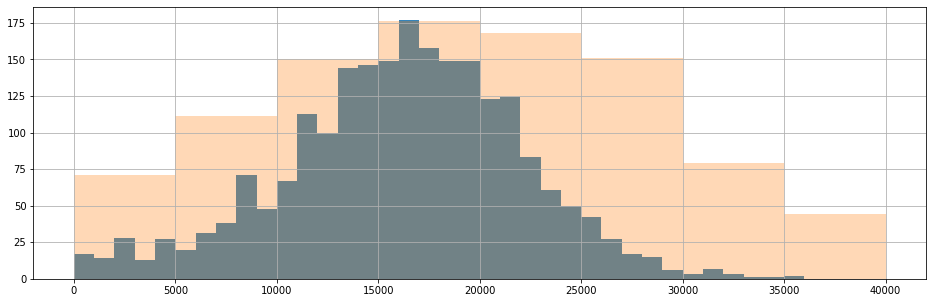

In [18]:
# Поделим наши DF по тарифам, чтобы дальше просто было удобней с этим работать
df_smart = df.query('tariff == "smart"')
df_ultra = df.query('tariff == "ultra"')

# Построим гистограмму для интернет-траффика
# Опятным путем подбираем интервалы для наших непрерывных значений
df_smart['month_mb_used'].hist(bins=[0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000, 21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,32000,33000,34000,35000,36000], figsize=(16,5), alpha=0.9)
df_ultra['month_mb_used'].hist(bins=[0,5000,10000,15000,20000,25000,30000,35000,40000], figsize=(16,5), alpha=0.3)

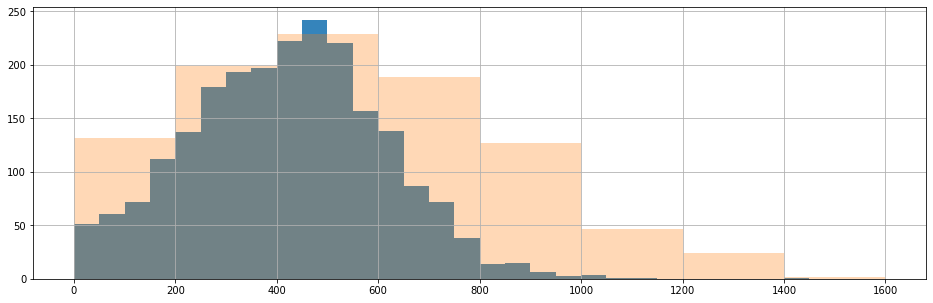

In [19]:
# Аналогично построим гистограмму для звонков
# На этот раз сформируем корзины автоматически

def make_bins(step, maximum):
    maximum_calculated = int(math.ceil(maximum / 100) * 100)
    elements_count = int(maximum_calculated / step) + 1
    
    bins = []
    for bin_element in range(elements_count):
        bins.append(bin_element * step)
        
    return bins

# шаг также подбираем индивидуально, это сильно влияет на то, каким будет распределение
# вероятно это связано с количеством данных и их разнородностью по тарифу ультра
bins_smart = make_bins(50, df_smart['month_call_duration'].max())
bins_ultra = make_bins(200, df_ultra['month_call_duration'].max())
    
df_smart['month_call_duration'].hist(bins=bins_smart, figsize=(16,5), alpha=0.9)
df_ultra['month_call_duration'].hist(bins=bins_ultra, figsize=(16,5), alpha=0.3)

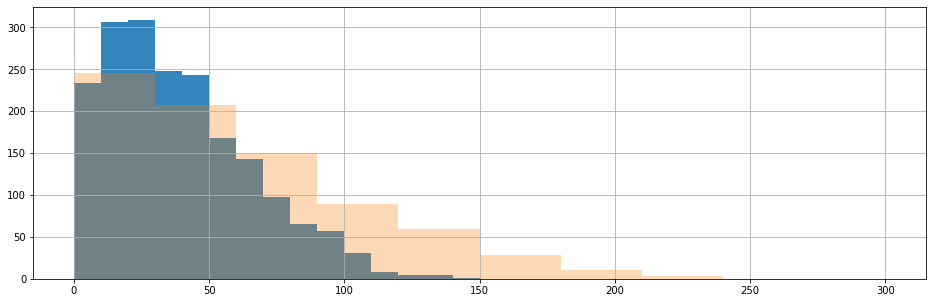

In [20]:
# Аналогично построим гистограммы для сообщений (month_message_count)

bins_smart = make_bins(10, df_smart['month_message_count'].max())
bins_ultra = make_bins(30, df_ultra['month_message_count'].max())

df_smart['month_message_count'].hist(bins=bins_smart, figsize=(16,5), alpha=0.9)
df_ultra['month_message_count'].hist(bins=bins_ultra, figsize=(16,5), alpha=0.3)

### Выводы по гистограммам

- Интернет-траффик и количество минут разговоров имеют нормальное распределение
- Количество сообщений описывается Пуассоновским распределением
- Количество минут для обоих тарифов скошено влево
- Количество трафика для тарифа ультра немного скошено вправо

## Cреднее, дисперсия и стандартное отклонение

In [21]:
# Посчитаем среднее, дисперсию и стандартное отклонение для наших тарифов
import numpy as np

def print_params_data(df):
    params_list = ['month_mb_used', 'month_call_duration', 'month_message_count', 'proceeds']

    for param in params_list:
        print(param + ':')
        print('AVG = ', round(df[param].mean(), 2)) # среднее
        print('MED = ', round(df[param].median(), 2)) # медиана
        print('VAR = ', round(np.var(df[param], ddof=1), 2)) # дисперсия, по выборке
        print('STD = ', round(np.std(df[param], ddof=1), 2)) # стандартное отклонение, по выборке
        print()

# выведем данные для смарт-тарифа
print('TARIFF: SMART')
print_params_data(df_smart)

TARIFF: SMART
month_mb_used:
AVG =  16236.47
MED =  16532.0
VAR =  34443100.68
STD =  5868.82

month_call_duration:
AVG =  419.06
MED =  423.0
VAR =  35844.19
STD =  189.33

month_message_count:
AVG =  38.72
MED =  34.0
VAR =  717.59
STD =  26.79

proceeds:
AVG =  1305.41
MED =  1043.0
VAR =  695214.13
STD =  833.8



In [22]:
# Выведем данные для ультра тарифа
print('TARIFF: ULTRA')
print_params_data(df_ultra)

TARIFF: ULTRA
month_mb_used:
AVG =  19686.77
MED =  19411.0
VAR =  99043439.61
STD =  9952.06

month_call_duration:
AVG =  545.45
MED =  528.0
VAR =  94203.42
STD =  306.93

month_message_count:
AVG =  61.16
MED =  51.0
VAR =  2109.66
STD =  45.93

proceeds:
AVG =  2073.05
MED =  1950.0
VAR =  148563.89
STD =  385.44



### Вывод

- Несмотря на то, что в уроках такие здоровые значения дисперсии и стандартного отклонения мы еще не видели, в контексте используемых единиц и временного промежутка, кажется что все в порядке. :)
- Медиана слабо отличается от среднего. Поэтому можно считать, что выбросов нет и спокойно работать со средним, т.к. в контексте наших вопросов это более интересная метрика.
- Пользователи тарифа ультра активней используют возможности своего тарифа
- А пользователи смарт плохо укладываются в ограничения своего тарифа и серьезно переплачивают

#### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

- Если говорить в среднем, то:
  - SMART
    - Трафик: 16,2 ГБ
    - Продолжительность звонков: 420 минут
    - Сообщений: 39
  - ULTRA
    - Трафик: 19,7 ГБ
    - Продолжительность звонков: 545 минут
    - Сообщений: 62
- Если говорить, сколько достаточно 99 процентам пользователей тарифа:
  - SMART
    - Трафик: 30,8 ГБ
    - Продолжительность звонков: 986 минут
    - Сообщений: 120
  - ULTRA
    - Трафик: 49,5 ГБ
    - Продолжительность звонков: 1463 минут
    - Сообщений: 197

# Проверим гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

## Выручка пользователей тарифов "Смарт" и  "Ультра"

Для начала сформулируем гипотезы H0 и H1.

Гипотеза H0: Средняя выручка от пользователей тарифа "Смарт" и тарифа "Ультра" одинакова (т.е. мы получаем одни деньги и там, и там)
Гипотеза H1: Выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается

Сформулируем это в коде

In [23]:
# Перенесем гипотезы в код
H0 = 'Не можем отвергнуть гипотизу - средняя выручка от пользователей тарифа "Смарт" и тарифа "Ультра" одинакова'
H1 = 'Можем отвергнуть нулевую гипотезу, выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается'

# проверим гипотезы
from scipy import stats as st

# зададим критический уровень статистической значимости в 5%
# почему именно в 5 - как одно из широко применяемых значений, точность в 1% в наших вопросах нам не нужна
alpha = 0.05 

# equal_var = False, т.к. совокупности по параметрам различаются
results = st.ttest_ind(df_smart['proceeds'], df_ultra['proceeds'], equal_var = False)

if (results.pvalue < alpha):
    print(H1)
else:
    print(H0)

Можем отвергнуть нулевую гипотезу, выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается


## Выручка пользователей из Москвы и других регионов

Для начала сформулируем гипотезы H0 и H1.

Гипотеза H0: Средняя выручка от пользователей Москвы и регионов одинакова
Гипотеза H1: Средняя выручка от пользователей Москвы и регионов различается

In [24]:
# выделим отдельно пользователей из Москвы и не из нее
df_moscow = df.query('city == "Москва"')
df_other = df.query('city != "Москва"')

# Перенесем гипотезы в код
H0 = 'Не можем отвергнуть гипотизу - cредняя выручка от пользователей Москвы и регионов одинакова'
H1 = 'Можем отвергнуть нулевую гипотезу, cредняя выручка от пользователей Москвы и регионов различается'

# equal_var = True, т.к. совокупности по параметрам не должны различаться
results = st.ttest_ind(df_moscow['proceeds'], df_other['proceeds'], equal_var = True)

if (results.pvalue < alpha):
    print(H1)
else:
    print(H0)

Не можем отвергнуть гипотизу - cредняя выручка от пользователей Москвы и регионов одинакова


## Вывод по гипотезам

- Мы отвергли гипотезу о равенстве выручки пользователей по тарифам, однако степень этой разницы и знак нужно исследовать дополнтельно
- При этом внезапно, с большой долей вероятности средняя выручка пользователей Москвы и регионов оказалась одинакова

# Общий вывод

Для формулировки итогового вывода, нужно обратиться к тому вопросу, что ставили перед нами изначально.

А именно - коммерческий департамент хочет понять, какой тариф приносит больше денег, сделать вывод — какой тариф лучше.

По большому счету, для этого достаточно было бы посмотреть на среднюю выручку и в ней явно выигрывает тариф "Ультра". Хотя тариф "Смарт" я бы также не сбрасывал со счетов, т.к. его пользователи часто переплачивают за услуги связи. К тому же, этот факт можно использовать, чтобы стимулировать их к переходу на тариф "Ультра". 

В целом, предоставляемое тарифом Ультра зачастую избыточно и можно считать, что пользователи переплачивают. Но, думаю, нашему коммерческому отделу это не очень интересно :)

